<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/amadeus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
# """ START UP """
# import os
# import shutil
# if os.path.exists('/content/HiloCATsSN1991bg') == True:
#     shutil.rmtree('/content/HiloCATsSN1991bg')
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
# else:
#     !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

# !pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
# !pip install requests
# !pip install sncosmo
# !pip install iminuit

In [121]:
""" IMPORTS """
import os
import time
import glob
import json
import snpy
import shutil
import sncosmo
import requests
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from zipfile import ZipFile
from requests.auth import HTTPBasicAuth
from HiloCATsSN1991bg.scripts import tns_redshifts
from astropy.table import QTable, Table, Column
from astropy import units as u

In [122]:
""" GLOBALS """
# TNS CREDINTIALS
tns_bot_id, tns_bot_name, tns_bot_api_key = '73181', 'YSE_Bot1', '0d771345fa6b876a5bb99cd5042ab8b5ae91fc67'

# PATHS
ROOT_PATH = '/content/HiloCATsSN1991bg/'

DATA_ATLAS = ROOT_PATH+'data/ATLAS/'

SNPY_ROOT = ROOT_PATH+'snpy/'
SNPY_BURNS = SNPY_ROOT+'burns/'
SNPY_BURNS_PLOTS = SNPY_BURNS+'plots/'

PLOTS_ROOT = ROOT_PATH+'plots/'

PROB_CHILD_TXT = SNPY_ROOT+'problem_children.txt'


In [123]:
""" GENERAL """
def recover_dir():
    directories = [ROOT_PATH,
                   DATA_ATLAS,
                   SNPY_ROOT, SNPY_BURNS, SNPY_BURNS_PLOTS,
                   PLOTS_ROOT]
    files = [PROB_CHILD_TXT]
    for dir in directories:
        if os.path.exists(dir) == False:
            os.mkdir(dir)
    for n_file in files:
        if os.path.exists(n_file) == False:
            with open(n_file, 'w') as f:
                pass
    return

def TNS_details(ra, dec):
    # Code from David
    headers = tns_redshifts.build_tns_header(tns_bot_id, tns_bot_name)
    tns_api_url = f"https://www.wis-tns.org/api/get"

    # get the API URLs
    search_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="search")
    get_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="get")

    search_data = tns_redshifts.build_tns_search_query_data(tns_bot_api_key, ra, dec)
    transients = tns_redshifts.rate_limit_query_tns(search_data, headers, search_tns_url)

    get_data = tns_redshifts.build_tns_get_query_data(tns_bot_api_key, transients[0])
    transient_detail = tns_redshifts.rate_limit_query_tns(get_data, headers, get_tns_url)

    return transient_detail

def snpy_fit(path, objname, fit_filters=None, skip_problems=False, use_saved=False, snpy_plots=True):
    problem_children = handle_problem_children(state='READ') # Open problem children

    if skip_problems and (objname in problem_children):
        return None
    else:
        try:
            if use_saved and os.path.exists(SNPY_BURNS+objname+'_EBV_model2.snpy'):
                n_s = snpy.get_sn(SNPY_BURNS+objname+'_EBV_model2.snpy')
            else:
                n_s = snpy.get_sn(path)
                n_s.choose_model('EBV_model2', stype='st')
                n_s.set_restbands() # Auto pick appropriate rest-bands
                n_s.fit(bands=fit_filters, dokcorr=True, k_stretch=False, reset_kcorrs=True, **{'mangle':1,'calibration':0})
                n_s.save(SNPY_BURNS+objname+'_EBV_model2.snpy')
                if snpy_plots:
                    n_s.plot(outfile=SNPY_BURNS_PLOTS+objname+'_snpyplots.png')
                    plt.show()
        except:
            problem_children = np.append(problem_children, objname)
            handle_problem_children(state='WRITE', problem_c=problem_children) # Commit problem children
            return None

    plt.close()
    return {'mu': n_s.get_distmod(), 'z': n_s.z, 'st': n_s.st, 'Tmax': n_s.Tmax, 'EBVHost': n_s.EBVhost}

def read_DR3(loc='/content/HiloCATsSN1991bg/DR3_fits.dat'):
    data = np.genfromtxt(loc, dtype=str, skip_header=1)
    dr3 = {}
    for n in range(len(data[:, 0])):
        dr3.update({data[:, 0][n]: {'st': float(data[:, 1][n]), 'e_st': float(data[:, 2][n]), 'z': float(data[:, 3][n]),
                           'Tmax': float(data[:, 5][n]), 'e_Tmax': float(data[:, 6][n]),
                           'EBVHost': float(data[:, 25][n]), 'e_EBVHost': float(data[:, 26][n])}})
    return dr3

def dict_unpacker(path, delimiter=', '):
    with open(path, 'r') as f:
        hdr = f.readline()[:-1].split(delimiter)

    data = np.genfromtxt(path, delimiter=delimiter, dtype=str, skip_header=1)
    temp_objs = {}
    for i in range(len(data[:, 0])):
        obj = data[:, 0][i]
        temp_objs.update({obj: {}})
        for j in range(len(hdr)):
            temp_objs[obj].update({hdr[j]: data[i, j]})
    return temp_objs

def dict_packer(data_dict, save_loc, delimiter=', '):
    catagories = list(data_dict[list(data_dict.keys())[0]].keys())
    with open(save_loc, 'w') as f:
        f.write('objname')
        for category in catagories:
            f.write(delimiter+category)
        f.write('\n')
        for objname in data_dict:
            f.write(objname)
            for category in catagories:
                f.write(delimiter+str(data_dict[objname][category]))
            f.write('\n')
    return

def handle_problem_children(state, problem_c=None):
    if state == 'READ':
        # Read problem children
        problem_c = np.genfromtxt(PROB_CHILD_TXT, dtype=str)
        return problem_c
    elif state == 'WRITE':
        # Write problem children
        problem_c = np.unique(problem_c)
        with open(PROB_CHILD_TXT, 'w') as f:
            for c in problem_c:
                f.write(c+'\n')
        return None
    else:
        raise Exception("Invalid state: '"+state+"' [READ/WRITE]")



In [124]:
""" BURNS/CSP """
def burns_cspvdr3():
    print('Fitting CSP data with SNooPy...')
    # Get Chris Burns Data
    objnames = np.genfromtxt('/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt', dtype=str, delimiter=', ')

    # Get CSP paths of Chris Burns Data
    objpaths = []
    for name in objnames:
        if os.path.exists('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt'):
            objpaths.append('/content/HiloCATsSN1991bg/data/CSPdata/SN'+name+'_snpy.txt')
        else:
            print(name, 'not found...')

    objs = {}
    for n in range(len(objpaths)):
        trakcer = '['+str(n+1)+'/'+str(len(objpaths))+']' # Purely cosmetic
        objname = objpaths[n][39:-9]
        temp_dict = snpy_fit(objpaths[n], objname, skip_problems=True, use_saved=True, snpy_plots=False)
        if temp_dict is not None:
            print(trakcer, objname, '\t| mu:', temp_dict['mu'], 'z =', temp_dict['z'], 'st =', temp_dict['st'], 'Tmax =', temp_dict['Tmax'], 'EBVHost =', temp_dict['EBVHost'])
            objs.update({objname: temp_dict})
        else:
            print(trakcer, objname, '\t| problem child, skipping...')

    dict_packer(objs, SNPY_BURNS+'saved.txt', delimiter=', ') # Save data from fitting

def burns_plotting(choice):
    if 'reg_hist' in choice:
        print('Ploting Histogram of SNooPy Fitting Parameters...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)
        reg_params = [st, Tmax, EBVHost]
        bins_reg = [15, 20, 15]
        plot_title = 'SNooPy Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(reg_params[i], bins=bins_reg[i])
            ax[i].set_title(titles[i])
        plt.show()

    if 'res_hist' in choice:
        print('Ploting Histogram of SNooPy-Chris Burns Parameters Residuals...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, st, Tmax, EBVHost = data[:, 0], data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)

        st_res, Tmax_res, EBVHost_res = [], [], []
        dr3 = read_DR3()
        for n in range(len(objnames)):
            if objnames[n] in dr3:
                st_res.append(st[n] - dr3[objnames[n]]['st'])
                Tmax_res.append(Tmax[n] - dr3[objnames[n]]['Tmax'])
                EBVHost_res.append(EBVHost[n] - dr3[objnames[n]]['EBVHost'])\

        res_params = [st_res, Tmax_res, EBVHost_res]
        bins_res = [30, 50, 20]
        plot_title = 'SNooPy-Chris Burns Parameters'

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        titles = ['st', plot_title+'\nTmax', 'EBVhost']
        for i in range(len(titles)):
            ax[i].hist(res_params[i], bins=bins_res[i])
            ax[i].set_title(titles[i])
        plt.show()

    if 'zvmu' in choice:
        print('Ploting redshift [z] vs distance mod [mu] of SNooPy Parameters...')
        data = np.genfromtxt(SNPY_ROOT+'saved.txt', dtype=str, delimiter=', ', skip_header=1)
        objnames, mu, z = data[:, 0], data[:, 1].astype(float), data[:, 2].astype(float)

        plt.figure(figsize=(8, 4))
        for n in range(len(objnames)):
            plt.loglog(z[n], mu[n], label=objnames[n], marker='o')
        plt.title('CSP Redshift vs. Distance Mod\n SNe # = '+str(len(objnames)))
        plt.xlabel('Redshift')
        plt.ylabel('Distance Mod')
        plt.legend()
        plt.show()

    return

In [125]:
""" ATLAS """

def atlas_collection(quiet=False, check_data=True):
    api_token = '7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4'

    if check_data and len(glob.glob(DATA_ATLAS+'*.txt')) > 1:
        print('ATLAS data already collected, passing step...')
        return
    else:
        print('No data detected, collecting ATLAS data...')
        if os.path.exists(DATA_ATLAS+'tmp.npz'):
            pickle = np.load(DATA_ATLAS+'tmp.npz', allow_pickle=True)
            data = pickle['data']

        data = requests.post('https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
                             headers={'Authorization': f'Token {api_token}'},
                             data={'objectlistid':2}).json()

        np.savez(DATA_ATLAS+'tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                count += 1
                if not quiet:
                    print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])


                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                if not quiet:
                    print(new_url)

                idfile = DATA_ATLAS+'/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                if not quiet:
                    print(idfile)

            if count > 300:
                break
    return

def atlas_processing():
    print('[2.1] Retrieving data from...', DATA_ATLAS)
    files = glob.glob(DATA_ATLAS+'/*')

    for n_file in files:
        data = np.genfromtxt(n_file, dtype=str, delimiter=',', skip_header=1)
        ra, dec = np.average(data[:, 1].astype(float)), np.average(data[:, 2].astype(float))
        objname = TNS_details(ra, dec)['objname']
        time = data[:, 8].astype(float)

        flux = data[:, 24]
        flux[np.where(flux == 'None')[0]] = np.nan
        flux = flux.astype(float)

        plt.scatter(time, flux)
        plt.show()

        # print()

        # dflux = data[:, 17].astype(float)

        # print(dflux)

        break
        # if len(data) == 0:
        #     print('[!!!] File '+n_file[48:-4]+' empty...skipping')




    # print('[2.2] Sorting data...')
    # SNe = []
    # tar_num = len(files)
    # for n in range(tar_num):
    #     n_name = files[n][48:-4]
    #     print('[', n+1, '/', len(files), '] Validating data for...', n_name)
    #     result = atlas_slice_data(path=files[n], err_max=err_max)
    #     if result != None:
    #         SNe.append(result)
    #     else:
    #         PROBLEM_CHILDREN.append(n_name)
    #     if n_iter != 0 and n+1 >= n_iter:
    #         break

    # print('[2.3] Problem Children: ', PROBLEM_CHILDREN)
    # for SN in SNe:
    #     for probname in PROBLEM_CHILDREN:
    #         if SN.ATLASname == probname:
    #             print('Removing...', SN.ATLASname)
    #             SNe.remove(SN)
    return

# def atlas_slice_data(path, err_max=100):
#     name = path[48:-4]
#     data = np.genfromtxt(path, dtype=str, delimiter=',')

#     if len(data) == 0:
#         print('[!!!] File '+name+' empty...skipping')
#         return None

#     filters = data[:, 6]
#     t = data[:, 8].astype(float)
#     flux = data[:, 24]
#     dflux = data[:, 25]
#     mag = np.char.replace(data[:, 3], '>', '') # Removes greater than symbols
#     dmag = data[:, 4]

#     # Finds the empty spots of flux and mag and records the element
#     mod_empty = np.unique(np.hstack((np.hstack((np.where(flux == 'None')[0], np.where(dflux == 'None')[0])),
#                                      np.hstack((np.where(mag == 'None')[0], np.where(dmag == 'None')[0])))))
#     filters = np.delete(filters, mod_empty)
#     t = np.delete(t, mod_empty).astype(float)
#     flux = np.delete(flux, mod_empty).astype(float)
#     dflux = np.delete(dflux, mod_empty).astype(float)
#     mag = np.delete(mag, mod_empty).astype(float)
#     dmag = np.delete(dmag, mod_empty).astype(float)

#     # Finds negative fluxes
#     mod_positive = np.unique(np.hstack((np.hstack((np.where(flux <= 0)[0], np.where(dflux <= 0)[0])),
#                                 np.hstack((np.where(mag <= 0)[0], np.where(dmag <= 0)[0])))))
#     filters = np.delete(filters, mod_positive)
#     t = np.delete(t, mod_positive)
#     flux = np.delete(flux, mod_positive)
#     dflux = np.delete(dflux, mod_positive)
#     mag = np.delete(mag, mod_positive)
#     dmag = np.delete(dmag, mod_positive)

#     # Find outliers beyond error limit
#     mod_err = np.unique(np.hstack(((np.where(abs(dflux) > err_max)[0]), np.where(abs(dmag) > err_max)[0]))) # Negatives fluxes & Error Limit
#     filters = np.delete(filters, mod_err)
#     t = np.delete(t, mod_err)
#     flux = np.delete(flux, mod_err)
#     dflux = np.delete(dflux, mod_err)
#     mag = np.delete(mag, mod_err)
#     dmag = np.delete(dmag, mod_err)

#     tempSN = ATLAS_SN(ATLASname=name, RA=np.average(data[:, 1].astype(float)), DEC=np.average(data[:, 2].astype(float)),
#                         t_o=t[np.where(filters=='o')[0]], flux_o=flux[np.where(filters=='o')[0]], dflux_o=dflux[np.where(filters=='o')[0]], mag_o=mag[np.where(filters=='o')[0]], dmag_o=dmag[np.where(filters=='o')[0]],
#                         t_c=t[np.where(filters=='c')[0]], flux_c=flux[np.where(filters=='c')[0]], dflux_c=dflux[np.where(filters=='c')[0]], mag_c=mag[np.where(filters=='c')[0]], dmag_c=dmag[np.where(filters=='c')[0]])

#     return tempSN

# def atlas_write_to_file(SNe, t_lim=0.1, save_loc=ROOT_SAVE+'ATLAS_variables.txt', quiet=False, use_saved=True):
#     # Check for presaved data
#     savedData = {}
#     if use_saved and os.path.exists(save_loc):
#         data = np.genfromtxt(save_loc, delimiter=', ', dtype=str, skip_header=1)
#         if len(data) > 0:
#             for n in range(len(data[:, 0])):
#                 savedData.update({data[n][1]: [data[n][0], data[n][4]]}) # atlasname: objname, z

#     with open(save_loc, 'w') as f:
#         f.write('objname, ATLASname, RA, DEC, z, tmin, tmax\n') # Header
#         for n in range(len(SNe)):
#             if SNe[n].ATLASname in savedData:
#                 obj = {'objname' : savedData[SNe[n].ATLASname][0], 'redshift' : savedData[SNe[n].ATLASname][1]}
#                 SNe[n].objname = obj['objname']
#                 SNe[n].z = obj['redshift']
#                 print("Saved object data found for "+SNe[n].ATLASname+", retrieving...")
#             else:
#                 print("No saved data, sleeping for", t_lim, 'seconds...')
#                 time.sleep(t_lim)
#                 obj = TNS_details(ra=SNe[n].RA, dec=SNe[n].DEC)
#                 SNe[n].objname = 'SN'+obj['objname']
#                 SNe[n].z = obj['redshift']

#             if len(SNe[n].t_o) > 0 and len(SNe[n].t_c) > 0:
#                 t_max = max([np.max(SNe[n].t_o), np.max(SNe[n].t_c)])
#                 t_min = min([np.min(SNe[n].t_o), np.min(SNe[n].t_c)])
#             elif len(SNe[n].t_o) == 0:
#                 t_max = np.max(SNe[n].t_c)
#                 t_min = np.min(SNe[n].t_c)
#             elif len(SNe[n].t_c) == 0:
#                 t_max = np.max(SNe[n].t_o)
#                 t_min = np.min(SNe[n].t_o)

#             if not quiet:
#                 print('[ '+str(n+1)+' / '+str(len(SNe))+' ]', SNe[n].ATLASname+':', SNe[n].objname,
#                       '| z =', SNe[n].z, '| Tmin:', t_min, 'Tmax:', t_max, '\n')
#             f.write(str(SNe[n].objname)+', '+str(SNe[n].ATLASname)+', '+str(SNe[n].RA)+', '+str(SNe[n].DEC)+', '+
#                     str(SNe[n].z)+', '+str(t_min)+', '+str(t_max)+'\n')
#     return SNe

# def atlas_write_ASCII(SNe, quiet=True, use_saved=True):
#     knownVariables = {}
#     skip_header = True
#     variables_path = ROOT_SAVE+'ATLAS_variables.txt'
#     if use_saved and os.path.exists(variables_path):
#         with open(variables_path, 'r') as f:
#             for line in f.readlines():
#                 if skip_header:
#                     skip_header = False
#                     pass
#                 else:
#                     line = line[:-1].split(', ')
#                     name = line[1]
#                     line.remove(name)
#                     knownVariables.update({name : line})

#     ATLASnames = []
#     for SN in SNe:
#         ATLASnames.append(str(SN.objname)+'_snpy.txt')
#         with open(SNPY_DATA_ATLAS_PATH+str(SN.objname)+'_snpy.txt', 'w') as f:
#             if not quiet:
#                 print(str(SN.objname)+' | z = '+str(SN.z)+', RA = '+str(SN.RA)+', DEC = '+str(SN.DEC))

#             # Line 1 -- Objname, Helio-Z, RA, Dec (Ex. SN1981D 0.005871 50.65992 -37.23272)
#             if SN.ATLASname in knownVariables.keys():
#                 SN.objname = knownVariables[SN.ATLASname][0]
#             else:
#                 print('No saved data for: '+str(SN.ATLASname)+', querying TNS...')
#                 SN.objname = TNS_details(ra=SN.RA, dec=SN.DEC)['objname']
#             f.write(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC)+'\n')

#             # 'o'/'ATri'-filter photometry block -- Date (JD/MJD), mag, err (674.8593 12.94 0.11)
#             f.write('filter ATri\n')
#             for i in range(len(SN.t_o)):
#                 f.write(str(SN.t_o[i])+'\t'+str(SN.mag_o[i])+'\t'+str(SN.dmag_o[i])+'\n')

#             # # 'c'/'ATgr'-filter photometry block
#             f.write('filter ATgr\n')
#             for i in range(len(SN.t_c)):
#                 f.write(str(SN.t_c[i])+'\t'+str(SN.mag_c[i])+'\t'+str(SN.dmag_c[i])+'\n')
#     return ATLASnames

# def atlas_fitting(SNe, save=True, output=True, show_plots=True, use_saved=True):
    fit_args = {'model': 'EBV_model2', 'shape': 'st', 'bands': ['ATgr', 'ATri'], 'output': output, 'show_plots': show_plots, 'use_saved': use_saved}
    paths = glob.glob(SNPY_DATA_ATLAS_PATH+'*')
    params = snpy_fit(paths, plot_save=PLOTS_ATLAS_PATH, model_save=SNPY_MODELS_ATLAS_PATH, **fit_args)

    SNe_new = [] # mu, z, st, Tmax, EBVhost, DM
    for SN in SNe:
        if SN.objname in params:
            SN.mu = params[SN.objname][0]
            SN.z = params[SN.objname][1]
            SN.st = params[SN.objname][2]
            SN.Tmax = params[SN.objname][3]
            SN.EBVhost = params[SN.objname][4]
            SN.DM = params[SN.objname][5]
            SNe_new.append(SN)
        else:
            print(SN.objname, 'is a problem child, removing...')

    # Save distance mod
    if save:
        saved_params = np.genfromtxt(ROOT_SAVE+'ATLAS_variables.txt', delimiter=', ', dtype=str, skip_header=1)
        with open(ROOT_SAVE+'ATLAS_variables_fit.txt', 'w') as f:
            f.write('objname, ATLASname, RA, DEC, z, tmin, tmax, mu, st, Tmax, EBVhost, DM\n')
            for n in range(len(SNe_new)):
                f.write(str(saved_params[n, 0])+', '+str(saved_params[n, 1])+', '+str(saved_params[n, 2])+', '+str(saved_params[n, 3])+', '+
                        str(saved_params[n, 4])+', '+str(saved_params[n, 5])+', '+str(saved_params[n, 6])+', '+str(SNe_new[n].mu)+', '+
                        str(SNe_new[n].st)+', '+str(SNe_new[n].Tmax)+', '+str(SNe_new[n].EBVhost)+', '+str(SNe_new[n].DM)+'\n')
    return SNe_new


[2.1] Retrieving data from... /content/HiloCATsSN1991bg/data/ATLAS/


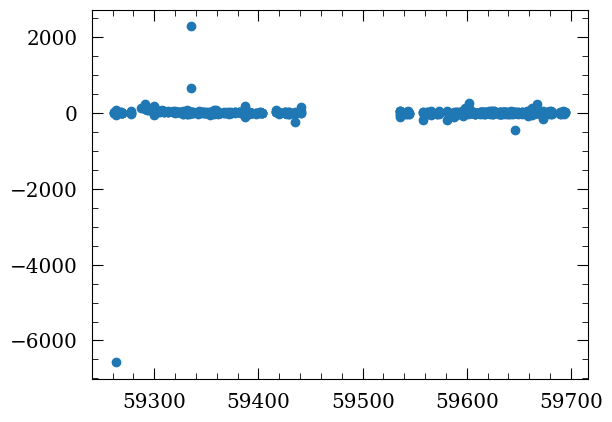

|---------------------------|
 Run-time:  2.2347 seconds
|---------------------------|


In [126]:
""" MAIN """
if __name__ == '__main__':
    start = time.time() # Runtime tracker

    recover_dir() # Recovering vital directories

    # burns_cspvdr3()
    # burns_plotting(['reg_hist', 'res_hist', 'zvmu']) # Options: ['reg_hist', 'res_hist', 'zvmu']

    # atlas_collection(quiet=False, check_data=True)
    atlas_processing()

    print('|---------------------------|\n Run-time: ', round(time.time()-start, 4), 'seconds\n|---------------------------|')